In [42]:
import pandas as pd
import geopandas as gpd
import osmnx as osm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from shapely.geometry import *

# 1) Data Cleaning

This notebook specifies and shows all the different steps that we will take to clean the data. 

We will do the following steps to clean the data:
1. Only consider the last 3 months of the data
2. Only consider weekdays
3. (Remove Outliers)
4. Only conider trips that are in Central London
5. Remove, rename and encode columns

## (0) Read in the Data:

In [43]:
trip_data = pd.read_csv('../Data/01_Raw_Data/bicycle_trip_data.csv')
num_rows_step0 = trip_data.shape[0]

/var/folders/0m/swmphxyn7jncj7fk8v1qrj5c0000gn/T/ipykernel_70746/564412933.py:1: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  trip_data = pd.read_csv('../Data/01_Raw_Data/bicycle_trip_data.csv')


## (1) Only consider the last 3 months of the data

In [44]:
#Only consider the last 3 months of the data
trip_data['Start date'] = pd.to_datetime(trip_data['Start date'])
trip_data = trip_data[trip_data['Start date'] >= trip_data['Start date'].max() - pd.Timedelta('90 days')]
num_rows_step1 = trip_data.shape[0]
print(f"First date: {trip_data['Start date'].min()}")
print(f"Last date: {trip_data['Start date'].max()}")
print(f"This step reduced the number of rows from {num_rows_step0} to {num_rows_step1} ({1-(num_rows_step1/num_rows_step0):.2%})")
print(f"In Comparison to the original data we now look at {(num_rows_step1/num_rows_step0):.2%} of the data.")

First date: 2024-02-01 00:00:00
Last date: 2024-05-01 00:00:00
This step reduced the number of rows from 13514122 to 1896920 (85.96%)
In Comparison to the original data we now look at 14.04% of the data.


## (2) Only consider weekdays

In [45]:
# Only consider weekdays
trip_data['weekday'] = trip_data['Start date'].dt.weekday
trip_data = trip_data[trip_data['weekday'] < 5]
num_rows_step2 = trip_data.shape[0]

print(f"This step reduced the number of rows from {num_rows_step1} to {num_rows_step2} ({1-(num_rows_step2/num_rows_step1):.2%})")
print(f"In Comparison to the original data we now look at {(num_rows_step2/num_rows_step0):.2%} of the data.")


This step reduced the number of rows from 1896920 to 1443245 (23.92%)
In Comparison to the original data we now look at 10.68% of the data.


## (3) Remove outliers (optional)
Exclude all trips that are 1.5 times the IQR above the third quartile and below the first quartile

In [46]:
#Remove outliers (optional): exclude all trips that are 1.5 times the IQR above the third quartile and below the first quartile
Q1 = trip_data['Total duration (ms)'].quantile(0.25)
Q3 = trip_data['Total duration (ms)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
trip_data = trip_data[(trip_data['Total duration (ms)'] >= lower_bound) & (trip_data['Total duration (ms)'] <= upper_bound)]
num_rows_step3 = trip_data.shape[0]

print(f"This step reduced the number of rows from {num_rows_step2} to {num_rows_step3} ({1-(num_rows_step3/num_rows_step2):.2%})")
print(f"In Comparison to the original data we now look at {(num_rows_step3/num_rows_step0):.2%} of the data.")

This step reduced the number of rows from 1443245 to 1382579 (4.20%)
In Comparison to the original data we now look at 10.23% of the data.


## (4) Only Consider central London

Import bike station data and convert it to a GeoDataFrame

In [47]:
station_data = pd.read_csv('../Data/01_Raw_Data/bike_stations.csv')
station_data_gpdf = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data['lon'], station_data['lat'], crs='epsg:4326'))
station_data_gpdf = osm.project_gdf(station_data_gpdf)

If no graph exists, create one and save it

In [48]:
new_map = False

if new_map:
    london = osm.graph_from_place('London, UK', network_type='bike')
    london = osm.project_graph(london)
    osm.io.save_graphml(london, filepath='../Data/02_Processed_Data/All_London_Bike.graphml')
else:
    london = osm.io.load_graphml('../Data/02_Processed_Data/All_London_Bike.graphml')

Plot the first graph

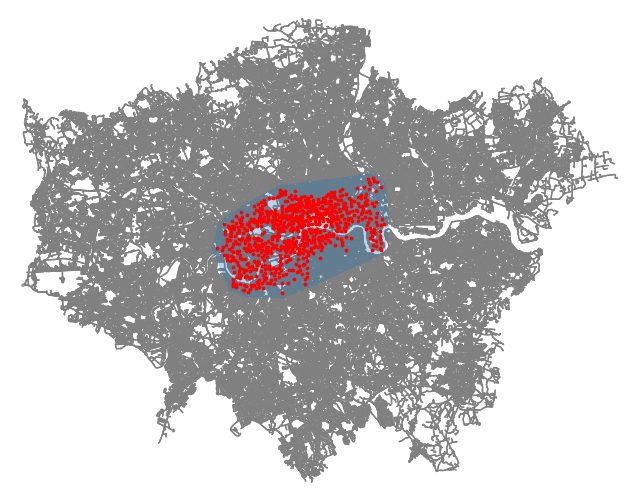

In [49]:
fix, ax = osm.plot_graph(london, node_size=3, bgcolor="none", edge_color="grey", node_color="none", show=False, close=False)
covered_area = station_data_gpdf.unary_union.convex_hull.buffer(500)
# Convert to lat/lon (graph_from_polygon requires lat/lon coordinates)
lat_lon_covered_area, crs = osm.projection.project_geometry(covered_area, crs=station_data_gpdf.crs, to_latlong=True)
gpd.GeoSeries(covered_area).plot(ax=ax, alpha=0.3)
station_data_gpdf.plot(ax=ax,color='r', markersize=3)
plt.show()

Define the central London boundary and plot it

Projected Bounding Box Coordinates:
North: 5713225.891915582
South: 5708105.6771600135
West: 696220.7716706274
East: 703385.7425126685
Number of bike stations within the bounding box: 370
Percentage of bike stations within the bounding box: 46.42%


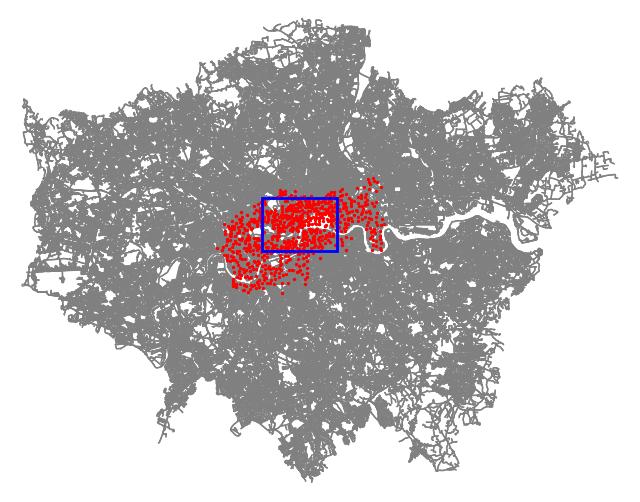

In [50]:
# Define the coordinates of the bounding box
north = 51.533448
south = 51.490000
west = -0.173492
east = -0.067472

# Get the CRS of the projected graph
crs_proj = london.graph['crs']
crs_proj

# Create a transformer to convert lat/lon to the projected CRS
transformer = Transformer.from_crs("epsg:4326", crs_proj, always_xy=True)

# Transform the bounding box coordinates to the projected CRS
west_proj, south_proj = transformer.transform(west, south)
east_proj, north_proj = transformer.transform(east, north)

# Print transformed coordinates to verify
print(f"Projected Bounding Box Coordinates:\nNorth: {north_proj}\nSouth: {south_proj}\nWest: {west_proj}\nEast: {east_proj}")

# Add the bounding box in the projected coordinates
bbox = Rectangle(
    (west_proj, south_proj),  # Bottom left corner (projected coordinates)
    east_proj - west_proj,  # Width (projected coordinates difference)
    north_proj - south_proj,  # Height (projected coordinates difference)
    linewidth=2,
    edgecolor='blue',
    facecolor='none'
)

# Plot the graph
fig, ax = osm.plot_graph(london, node_size=3, bgcolor="none", edge_color="grey", node_color="none", show=False, close=False)

# Plot the bike stations
station_data_gpdf.plot(ax=ax, color='r', markersize=2)

# Add the bounding box to the plot
ax.add_patch(bbox)

# Create a shapely box object for the bounding box
bounding_box = box(west_proj, south_proj, east_proj, north_proj)

# Perform a spatial query to count the number of bike stations within the bounding box
stations_within_bbox = station_data_gpdf[station_data_gpdf.geometry.within(bounding_box)]
num_stations = len(stations_within_bbox)

print(f"Number of bike stations within the bounding box: {num_stations}")
print(f"Percentage of bike stations within the bounding box: {num_stations / len(station_data_gpdf) * 100:.2f}%")
# Show the plot
plt.show()

Save Central London Graph

In [51]:
central_london = osm.graph_from_bbox(north=north, south=south, east=east, west=west, network_type='all')
central_london = osm.project_graph(central_london)
osm.io.save_graphml(central_london, filepath='../Data/02_Processed_Data/Central_london.osm')

/var/folders/0m/swmphxyn7jncj7fk8v1qrj5c0000gn/T/ipykernel_70746/1124800944.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  central_london = osm.graph_from_bbox(north=north, south=south, east=east, west=west, network_type='all')


Exclude all trips that are not in Central London

In [52]:
trip_data = trip_data[(trip_data['Start station'].isin(stations_within_bbox['commonName']) &  trip_data['End station'].isin(stations_within_bbox['commonName']))]
num_rows_step4 = trip_data.shape[0]

print(f"This step reduced the number of rows from {num_rows_step3} to {num_rows_step4} ({1-(num_rows_step4/num_rows_step3):.2%})")
print(f"In Comparison to the original data we now look at {(num_rows_step4/num_rows_step0):.2%} of the data.")


This step reduced the number of rows from 1382579 to 564757 (59.15%)
In Comparison to the original data we now look at 4.18% of the data.


## (5) Remove, rename and encode columns

In [53]:
# check if there are double entries in stations_within_bbox for the column commonName
stations_within_bbox['commonName'].duplicated().any()


False

In [55]:
# Weekday was only uesd to filter the data
trip_data = trip_data.drop(columns=['weekday'])

# Unnamed: 0 is not needed and only a copy of the original index
trip_data = trip_data.drop(columns=['Unnamed: 0'])

# The total duration is already given in milliseconds
trip_data = trip_data.drop(columns=['Total duration'])

# All the Bike station IDs are not needed as they don't match in both data sets
trip_data = trip_data.drop(columns=['Start station number', 'End station number'])
stations_within_bbox = stations_within_bbox.drop(columns=['Unnamed: 0',	'id', 'geometry'])
num_rows_step5 = trip_data.shape[0]

print(f"This step reduced the number of rows from {num_rows_step4} to {num_rows_step5} ({1-(num_rows_step5/num_rows_step4):.2%})")
print(f"In Comparison to the original data we now look at {(num_rows_step5/num_rows_step0):.2%} of the data.")


This step reduced the number of rows from 564757 to 564757 (0.00%)
In Comparison to the original data we now look at 4.18% of the data.


In [57]:
# Add the lat_start, lon_start, lat_end, lon_end to the trip_data
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='Start station', right_on='commonName', suffixes=('', '_start'))
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='End station', right_on='commonName', suffixes=('', '_end'))
# drop the commonName columns
trip_data.drop(columns=['commonName', 'commonName_end'], inplace=True)
# rename the lat and lon column to lat_start, lon_start
trip_data.rename(columns={'lat': 'lat_start', 'lon': 'lon_start'}, inplace=True)

## Export the cleaned data

In [58]:
trip_data.to_csv('../Data/02_Processed_Data/cleaned_trip_data.csv', index=False)
stations_within_bbox.to_csv('../Data/02_Processed_Data/cleaned_station_data.csv', index=False)